In [2]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()


We are using the training set 2 because we need to understand how to tune the threshold on the reconstruction error that we obtain using PCA.

In [3]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

discrete_variables = [f'S_PU{num+1}' for num in range(11)] + ['S_V2']    
data_trn_2 = data_trn_2.drop(columns=discrete_variables)

labels = data_trn_2['ATT_FLAG']

data_trn_2.drop(columns=['ATT_FLAG'], inplace=True)

remapping_positives = 50
labels = labels.map({-999: 0, 1: remapping_positives}) # this remapping is just useful for the coming visualisations, nothing to worry about

First of all... NORMALIZATION!

In [4]:
df_mean_trn = data_trn_2.mean()
df_std_trn = data_trn_2.std()
normalized_df=(data_trn_2-df_mean_trn)/df_std_trn
# normalized_df.head()

# remove columns with NaN (they had only the same value --> not possible to normalize them)
print(normalized_df.columns[normalized_df.isna().any()].tolist())
# spoiler: we will need to remove these columns also from the testset when we will do anomaly detection


normalized_df.dropna(axis='columns', inplace=True)
# normalized_df.head()

['F_PU3', 'F_PU5', 'F_PU9']


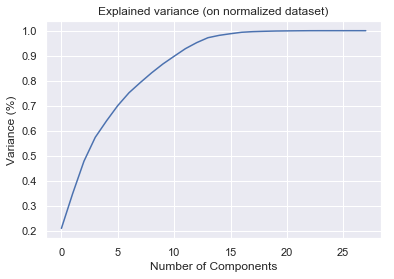

In [5]:
n_of_components = normalized_df.shape[1]
pca_fit = PCA(n_of_components).fit(normalized_df)

plt.figure()
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained variance (on normalized dataset)')
plt.show()

Let's create a function that retrieves the number of principal components that we need if we want to capture a certain percentage of variance in the data

In [6]:
def get_num_of_principal_components(fitted_pca, desired_variance_perc):
    cumulative_variance = np.cumsum(fitted_pca.explained_variance_ratio_)
    return [i for i in range(len(cumulative_variance)) if cumulative_variance[i] > desired_variance_perc/100][0]

Let's use this number of components to project the data into a lower dimensional feature space. In order to capture the normal behaviour (and therefore being able to detect anomalies) we need to capture enough variance of the data, but not too much. Otherwise we would also learn about the anomalies. This is actually the power of PCA!

In [7]:
var_perc_to_capture = 80  # we want to capture 80% of the variance, to capture the normal behavior

n = get_num_of_principal_components(pca_fit, var_perc_to_capture)
print(f"{n} components will be used to project into the normal space")

pca = PCA(n_components=n)
df_pca = pd.DataFrame(pca.fit_transform(normalized_df), normalized_df.index)
df_pca.head()

8 components will be used to project into the normal space


,0,1,2,3,4,5,6,7
2016-07-04 00:00:00,-0.082076,-0.837768,1.910539,2.145791,1.294063,-1.166258,-1.458788,0.226568
2016-07-04 01:00:00,0.661386,2.600156,2.744080,1.470052,-1.703856,1.445069,-1.978776,0.401724
2016-07-04 02:00:00,0.925890,2.914836,2.525965,1.639343,-2.824240,1.842735,-0.503092,-0.494058
2016-07-04 03:00:00,-1.312981,3.521166,1.776369,0.520519,1.390012,2.456869,2.991624,-1.123721
2016-07-04 04:00:00,-0.972529,4.012716,1.987852,-0.219327,2.350952,2.223345,1.155876,-0.239867


Let's now reconstruct the original data from the lower-dimensional projection that we obtain with PCA

In [8]:
df_reconstructed = pd.DataFrame(pca.inverse_transform(df_pca), normalized_df.index)
df_reconstructed.columns = normalized_df.columns

# print(normalized_df.shape)
# print(df_reconstructed.shape)

# Now, we compute the residuals: original normalized data - reconstructed data

residual_df = normalized_df.subtract(df_reconstructed)

We want to see what the residual obtained with PCA reconstruction is. We use sensors for which we know there has been attacks in this training set.

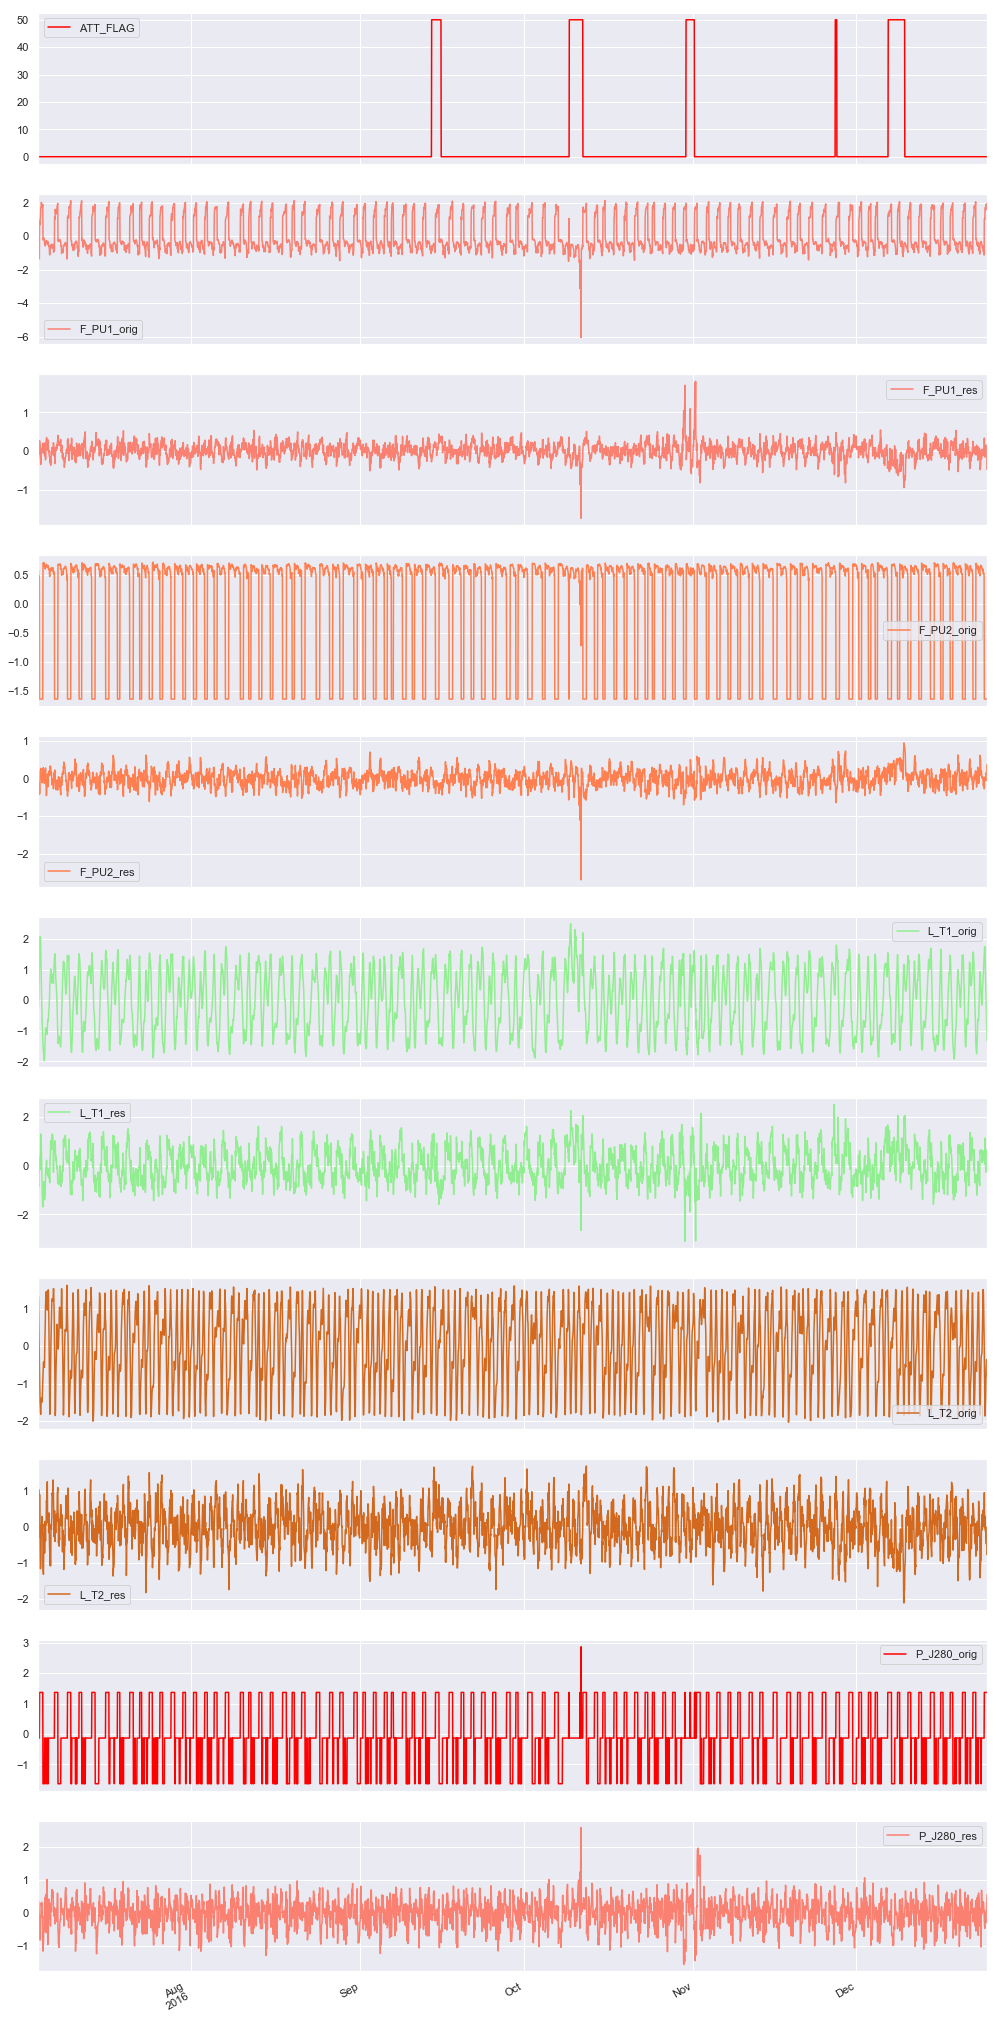

In [9]:
cols_plot = ['L_T1', 'F_PU1', 'F_PU2', 'P_J280', 'L_T2']
original = normalized_df[cols_plot]
original.columns = [col + "_orig" for col in cols_plot]

residuals = residual_df[cols_plot]
residuals.columns = [col + "_res" for col in cols_plot]


to_plot_df = pd.concat([original, residuals, labels], axis=1)
to_plot_df.index = normalized_df.index

to_plot_df = to_plot_df[sorted(to_plot_df.columns)] # this is done just to reorder them and having an ordered plot

# to_plot_df.loc['2016-10-01':'2016-11-10'].plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
to_plot_df.plot(figsize=(17, 40), subplots=True, color=['red', 'salmon', 'salmon', 'coral', 'coral', 'lightgreen', 'lightgreen', 'chocolate', 'chocolate'])
plt.show()

It seems like PCA is actually able to detect some of the anomalies (other attacks are related to other sensors which are not displayed here!)

Let's now square the residuals (we are not interested in the sign) and sum across all the sensors --> we have an overall idea of the PCA residuals over the whole system. In the assignment it is asked to plot the residuals in one signal, hence why.

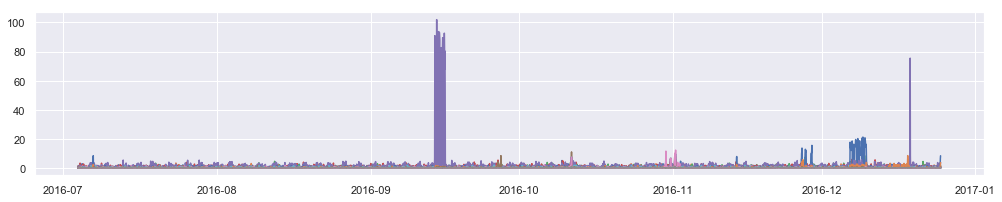

In [67]:
squared_res_df = pd.DataFrame(np.power(residual_df, 2), residual_df.index)

# Let's just have a look at the different residuals altogether
plt.figure(figsize=(17,3))
plt.plot(squared_res_df)
plt.show()

Now, let's sum all these squared residuals, so that we can plot them in one single signal (as requested)!

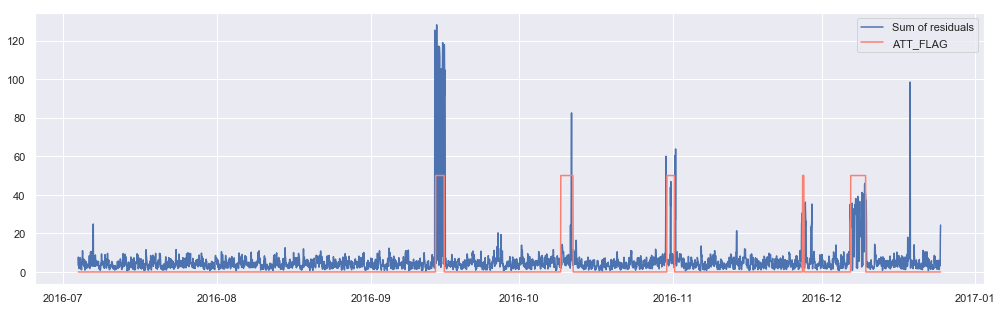

In [69]:
squared_sum_res = squared_res_df.sum(axis=1)
plt.figure(figsize=(17,5))
plt.plot(squared_sum_res, label='Sum of residuals')
plt.plot(labels, color='salmon')
plt.legend()
plt.savefig(r"../images/PCA_residuals_single_signal.pdf")
plt.show()

Some of the attacks can be clearly found using the residuals. Also, it seems there are some attacks which are not labeled (on https://batadal.net/data.html they say "This dataset with partially labeled data was released on November 28 2016. The dataset is around 6 months long and contains several attacks, some of which are approximately labeled")

### Threshold setup

Let's have a look at the eigenvalues we have

In [12]:
print(f"{n} components used to capture normal behaviour: ")
normal_eigvals = pca_fit.explained_variance_[:n]
print(normal_eigvals)

print(f"\n\n{normalized_df.shape[1] - n} components used to capture anomalies:")
abnormal_eigvals = pca_fit.explained_variance_[n:]
print(abnormal_eigvals)

8 components used to capture normal behaviour: 
[5.87531288 3.90055973 3.61600714 2.67032615 1.84395347 1.71493388
 1.43792837 1.1387088 ]


20 components used to capture anomalies:
[1.08373361e+00 9.91125425e-01 8.67681967e-01 8.47994587e-01
 6.75774451e-01 5.51129565e-01 2.64700501e-01 1.83292834e-01
 1.61684080e-01 7.06658332e-02 3.78171886e-02 2.93164407e-02
 1.44895357e-02 1.16579382e-02 9.30031485e-03 1.73607770e-03
 1.06445438e-04 5.95523519e-05 2.22079185e-06 1.01164375e-06]


We need to compute a threshold for the residual error, as explained in the paper about PCA. (Diagnosing Network-wide traffic anomalies)

Threshold: 26.62765981835184


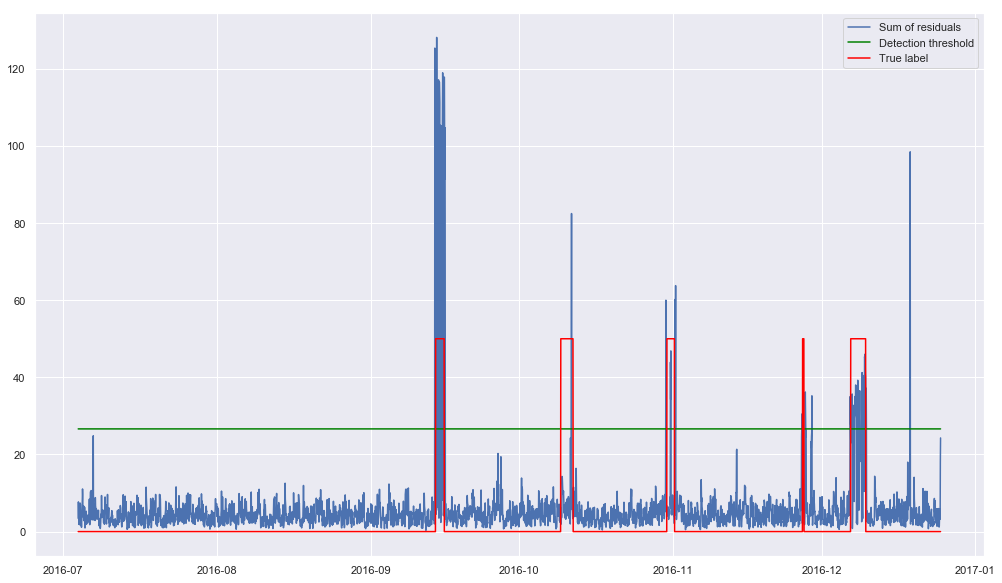

In [25]:
r = n # number of normal components for us

phi_1 = np.sum(abnormal_eigvals)
phi_2 = np.sum(np.power(abnormal_eigvals, 2))
phi_3 = np.sum(np.power(abnormal_eigvals, 3))

h_0 = (2 * phi_1 * phi_3) / (3 * phi_2**2)
h_0 = 1 - h_0

# c_alpha is a hyperparameter, also in the paper.
# we performed a grid search with values of c_alpha from 1 to 6, with step 0.25
c_alpha = 3.75 # This value leads to a 'few false positives', as requested in the assignment paper.

# multiple steps to make it understandable
delta_alpha_squared = 0
delta_alpha_squared += c_alpha * np.sqrt(2 * phi_2 * h_0**2) / phi_1
delta_alpha_squared += 1
delta_alpha_squared += phi_2 * h_0 * (h_0 - 1) / (phi_1**2)
delta_alpha_squared **= (1/h_0)
delta_alpha_squared *= phi_1

print(f"Threshold: {delta_alpha_squared}")

detection = squared_sum_res > delta_alpha_squared
detection = detection.astype(int)
detection = detection.map({0:0, 1:(remapping_positives)}) # remapping_positives is defined at the beginning of the . This is just for putting values on a scale that makes the visualization nice

threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(detection.shape[0])]), detection.index)


plt.figure(figsize=(17,10))
plt.plot(squared_sum_res, label='Sum of residuals')
plt.plot(threshold, label='Detection threshold', color='green')
plt.plot(labels, color='red', label='True label')
plt.legend()
plt.show()

Let's compute some metrics to see how good this detection on the training data is

In [62]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function
    result = results[
        (results['true'] == (remapping_positives if true_attack else 0)) 
        & 
        (results['pred'] == (remapping_positives if pred_attack else 0))
    ]
#     display(result.head())
    return result.shape[0]

res = pd.concat([labels, detection], axis=1)
res.columns = ['true', 'pred']

t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

precision = t_p/(t_p + f_p)
recall = t_p/(t_p + f_n)

f1 = ( 2 * precision * recall ) / (precision + recall )
print(f"TP: {t_p}. FP:{f_p}. TN:{t_n}. FN: {f_n}")
print(f"Prec: {precision}, Rec: {recall}")
print(f"f1: {f1}")
print(f"{f_p} false positives out of {t_p + f_p} attacks detected. ({t_p + f_n} attacks were labeled) --> {t_p} attacks correctly detected!")


TP: 73. FP:26. TN:3932. FN: 146
Prec: 0.7373737373737373, Rec: 0.3333333333333333
f1: 0.45911949685534587
26 false positives out of 99 attacks detected. (219 attacks were labeled) --> 73 attacks correctly detected!


It is said that the dataset is partially labeled, so maybe our false positives are not that false, afterall. Actually, by looking at the image about attacks on the BATADAL website, all these detected attacks are real attacks!

## Investigation on the type of anomalies that we can detect with PCA

We will now investigate the True Positives, to understand what we are able to detect with using PCA

In [27]:
detected = res[(res['true'] == remapping_positives) & (res['pred'] == remapping_positives)]
print(detected.index[0])
print(detected.index[-1])

2016-09-14 03:00:00
2016-12-09 21:00:00


All detected anomalies are from September 2016 to the end of the data (end of 2016). Therefore, we focus only on this slice of data

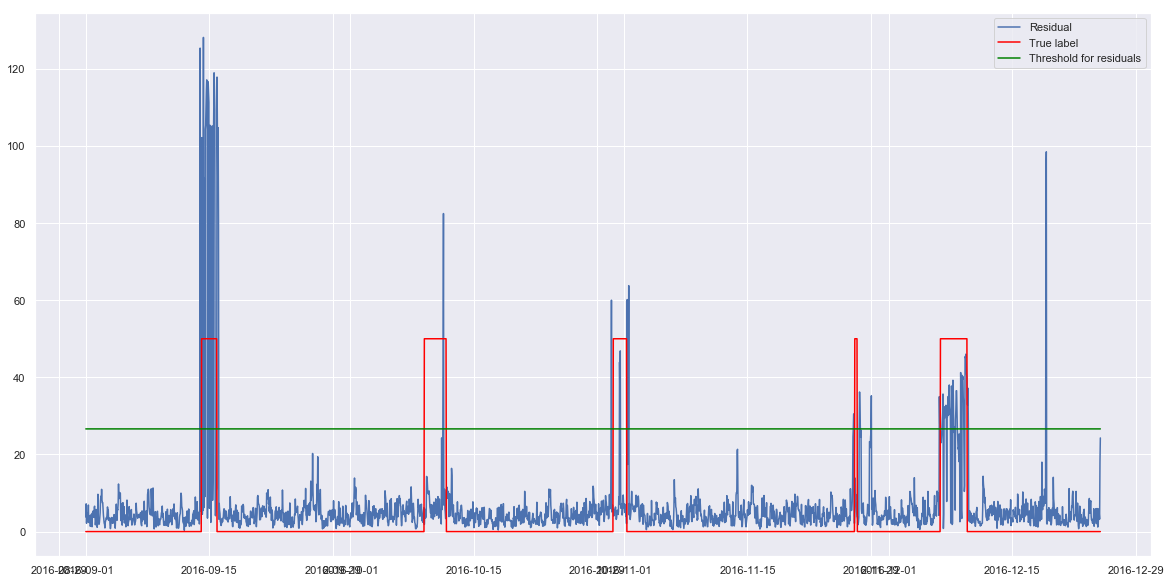

In [28]:
start = '2016-09'
end = '2016-12-29'

plt.figure(figsize=(20,10))
plt.plot(squared_sum_res.loc[start:end], label='Residual')
plt.plot(labels.loc[start:end], color='red', label='True label')
plt.plot(threshold.loc[start:end], color='green', label='Threshold for residuals')
plt.legend()
plt.show()

It seems PCA is able to detect almost perfectly **two** of the anomalies that we see here: around September 2016 and around the first half of December 2016.       
Let's look at the first one. By looking at the labels for this dataset, the attack interested tower 7. Therefore, we show here signals relevant for this attack.

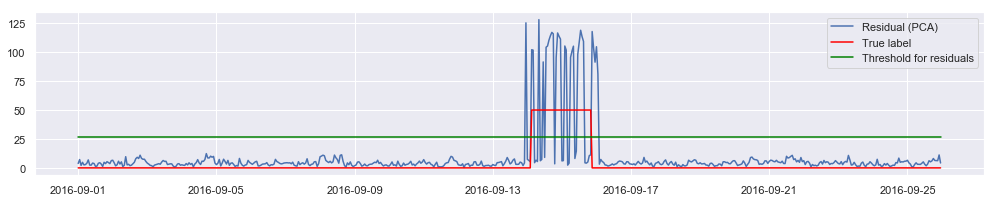

In [56]:
start = '2016-09-01'
end = '2016-09-25'
cols_plot = ['L_T7', 'F_PU10', 'F_PU11']


plt.figure(figsize=(17,3))
plt.plot(squared_sum_res.loc[start:end], label='Residual (PCA)')
plt.plot(labels.loc[start:end], color='red', label='True label')
threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(detection.shape[0])]), detection.index)
plt.plot(threshold.loc[start:end], color='green', label='Threshold for residuals')
plt.legend()
plt.show()

Let's see what kind of shape this anomaly has, by looking at the original signals

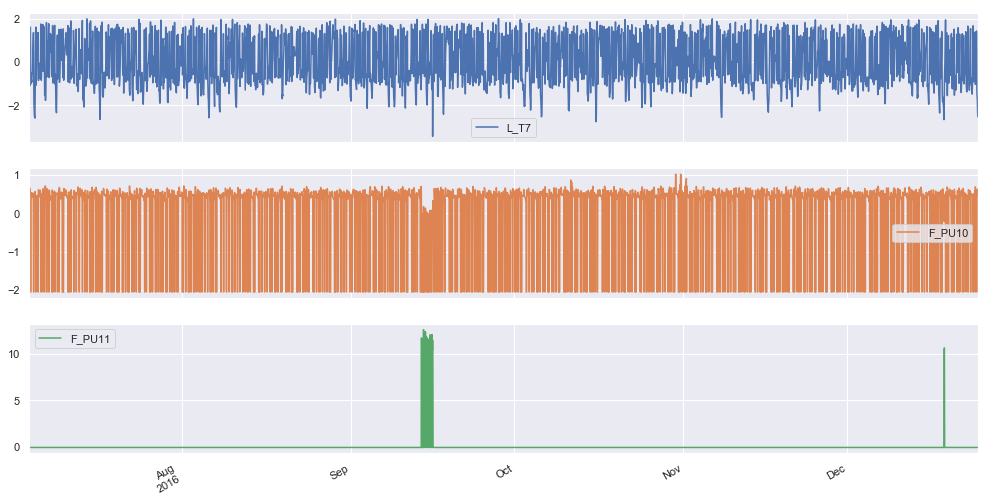

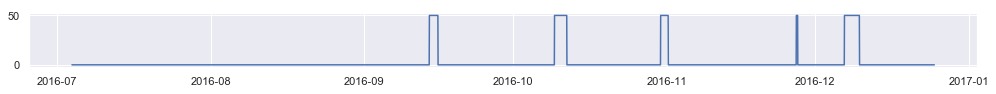

In [44]:
normalized_df[cols_plot].plot(subplots=True, figsize=(17,3*len(cols_plot)))
plt.show()

plt.figure(figsize=(17,1))
plt.plot(labels)
plt.show()

This is definitely a **point anomaly**: the level of water reached by 'L_T7' is the lowest across the whole timeseries. Therefore, it does not depend on any context, and it is anomalous by itself.

Let's now move to the second detected anomaly: December 2016

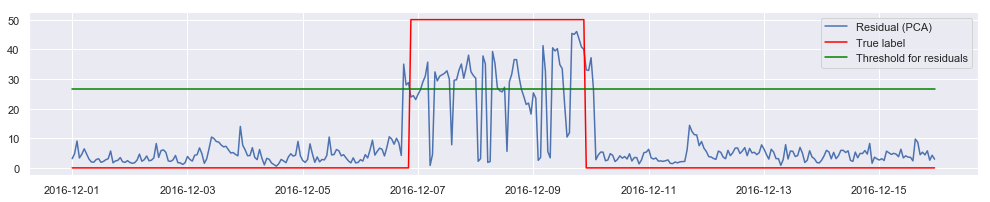

In [57]:
start = '2016-12-01'
end = '2016-12-15'
cols_plot = ['L_T4', 'F_PU7']



plt.figure(figsize=(17,3))
plt.plot(squared_sum_res.loc[start:end], label='Residual (PCA)')
plt.plot(labels.loc[start:end], color='red', label='True label')
threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(detection.shape[0])]), detection.index)
plt.plot(threshold.loc[start:end], color='green', label='Threshold for residuals')
plt.legend()
plt.show()

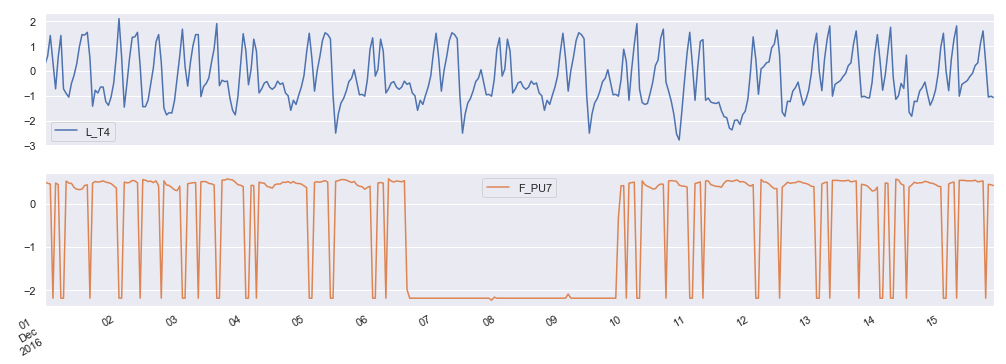

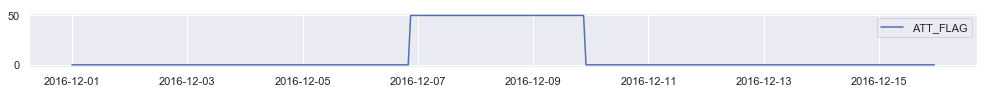

In [39]:
normalized_df[cols_plot].loc[start:end].plot(subplots=True, figsize=(17,3*len(cols_plot)))
plt.show()

plt.figure(figsize=(17,1))
plt.plot(labels.loc[start:end])
plt.legend()
plt.show()

This is a **collective anomaly**, because F_PU7 can take on this low value without it being an anomaly. The problem is when these values occur together as a collection. As explained in the anomaly taxonomy in the anomaly detection survey paper: __The individual data instances in a collective anomaly may not be anomalies by themselves,
but their occurrence together as a collection is anomalous__

Now, let's look at one anomaly which has been detected by PCA, but not fully nor in a satisfying amount. This is the anomaly happened around the 10th of October 2016, and interested 'L_T1' and other signals (please, see the label data on batadal website)

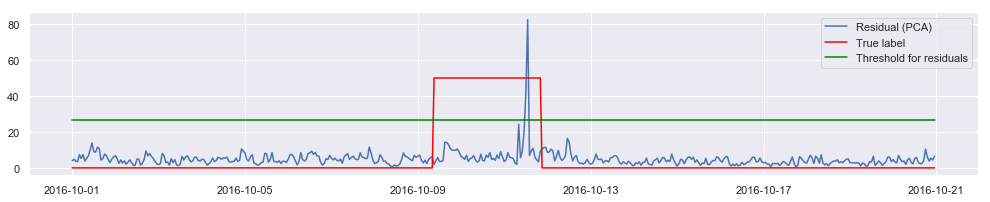

In [60]:
start = '2016-10-01'
end = '2016-10-20'
cols_plot = ['L_T1', 'F_PU1', 'F_PU2']



plt.figure(figsize=(17,3))
plt.plot(squared_sum_res.loc[start:end], label='Residual (PCA)')
plt.plot(labels.loc[start:end], color='red', label='True label')
threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(detection.shape[0])]), detection.index)
plt.plot(threshold.loc[start:end], color='green', label='Threshold for residuals')
plt.legend()
plt.show()

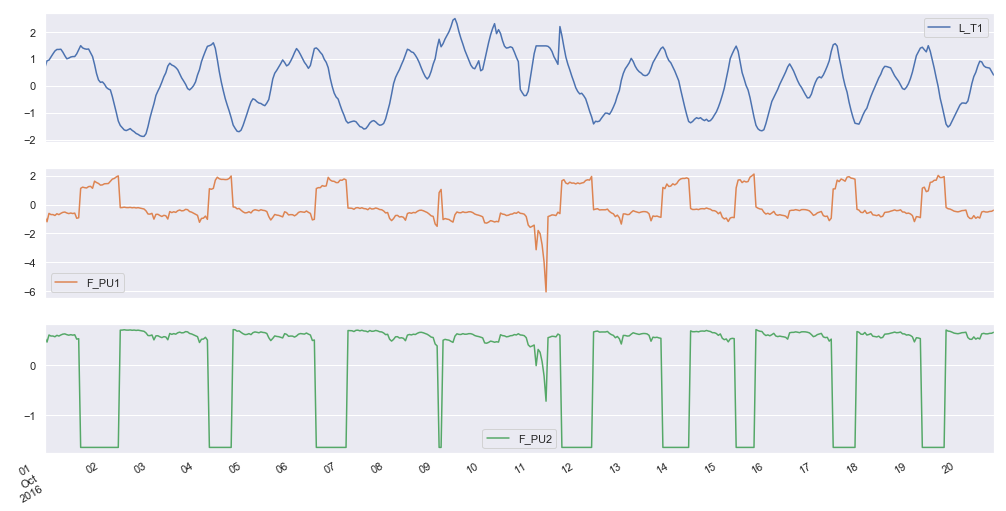

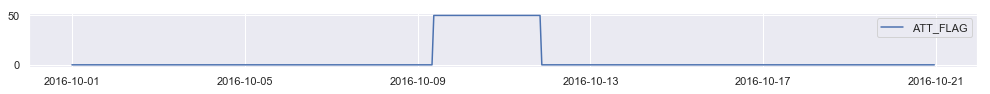

In [61]:
normalized_df[cols_plot].loc[start:end].plot(subplots=True, figsize=(17,3*len(cols_plot)))
plt.show()

plt.figure(figsize=(17,1))
plt.plot(labels.loc[start:end])
plt.legend()
plt.show()

The first part of the anomaly looks like a **behavioral anomaly**, because the values that 'F_PU2' takes on are normal in other contexts, but not in this case (2016-10-09): the problem is that the low value lasts for a very short amount of time, and then goes up immediately (this is the abnormal behaviour!). The secondo part of the anomaly, which is successfully detected, is a **point anomaly**: Values of 'F_PU1', 'F_PU2' take on values which almost never happen in the normal behaviour, and therefore PCA is able to detect them. To sum up, we believe PCA can detect Point and Collective anomalies, while has problems in detecting contextual anomalies.

# Testing on the test set (not mandatory, but we were curious!)

In [31]:
file_name = "test_set"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_test = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_test.index = pd.DatetimeIndex(data_test.index.values, freq = data_test.index.inferred_freq)

# normalize using mean and standard deviation from the training set (https://www.researchgate.net/post/If_I_used_data_normalization_x-meanx_stdx_for_training_data_would_I_use_train_Mean_and_Standard_Deviation_to_normalize_test_data)
data_test = (data_test-df_mean_trn)/df_std_trn

discrete_variables = [f'S_PU{num+1}' for num in range(11)] + ['S_V2']    
data_test = data_test.drop(columns=discrete_variables + ['F_PU3', 'F_PU5', 'F_PU9']) # remove also features which could not be normalized when training PCA

# we do not have any labels here

# we are going to use the pca that we obtained in the training set to see if we can detect anomalies in the test set
df_test_pca = pd.DataFrame(pca.transform(data_test), data_test.index)

# reconstruct dataframe
df_test_reconstructed = pd.DataFrame(pca.inverse_transform(df_test_pca), df_test_pca.index)
df_test_reconstructed.columns = data_test.columns

# Now, we compute the residuals: original normalized data - reconstructed data
residual_test_df = data_test.subtract(df_test_reconstructed)
squared_res_test_df = pd.DataFrame(np.power(residual_test_df, 2), residual_test_df.index)
squared_sum_test_res = squared_res_test_df.sum(axis=1)

# threshold tuned on the training
threshold = pd.DataFrame(np.array([delta_alpha_squared for i in range(squared_sum_test_res.shape[0])]), squared_sum_test_res.index)


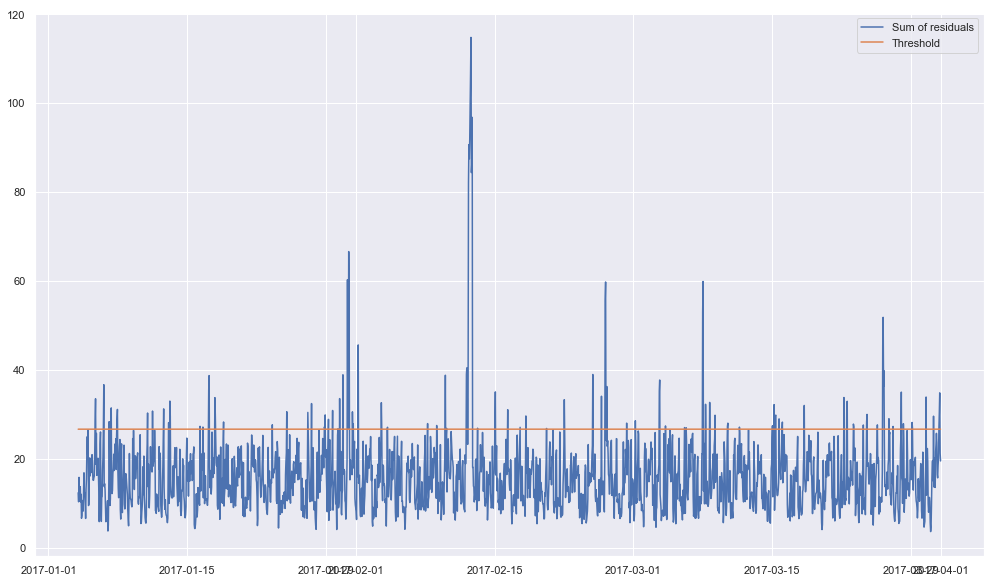

In [32]:
plt.figure(figsize=(17,10))
plt.plot(squared_sum_test_res, label='Sum of residuals')
plt.plot(threshold, label='Threshold')
plt.legend()
plt.show()

By visual inspection, it seems that all the attacks found in the test set are found with PCA (although the threshold should be higher than the one we obtained with gridsearch on the training set). Remember, the threshold that we are using here was tuned on the training set.    
We believe that, with some more optimization (different number of principal components, removing noise from the signal, ...) we could definitely identify a threshold which would lead to an very good detection on the testset.

Unfortunately, it seems there are quite a few false positives on this test set, but we cannot quantify precision and recall because we do not have labels for the this dataset.